In [22]:
import pandas as pd
import descarteslabs as dl
import matplotlib.pyplot as plt
from osgeo import gdal
import os
import numpy as np
import json
import datetime
import warnings
# warn this
warnings.filterwarnings('ignore')

### Build your own GeoJSON!
It's fun!

http://geojson.io/

In [23]:
smith_river = {
        "type": "Polygon",
        "coordinates": [
          [
            [
              -124.14482116699219,
              41.751592536486534
            ],
            [
              -123.96835327148436,
              41.751592536486534
            ],
            [
              -123.96835327148436,
              41.88362062793374
            ],
            [
              -124.14482116699219,
              41.88362062793374
            ],
            [
              -124.14482116699219,
              41.751592536486534
            ]
          ]
        ]
      }

In [24]:
scenes, ctx = dl.scenes.search(smith_river,
                    products=["sentinel-2:L1C"],
                    start_datetime="2016-03-20",
                    cloud_fraction=0.05,
                    limit=1000
                   )

https://docs.descarteslabs.com/descarteslabs/scenes/readme.html

In [25]:
scenes

SceneCollection of 132 scenes
  * Dates: May 08, 2016 to Dec 02, 2018
  * Products: sentinel-2:L1C: 132

In [26]:
scenes.each.properties.id

'sentinel-2:L1C:2016-05-08_10TCM_54_S2A_v1'
'sentinel-2:L1C:2016-05-08_10TDM_99_S2A_v1'
'sentinel-2:L1C:2016-05-28_10TCM_54_S2A_v1'
'sentinel-2:L1C:2016-05-28_10TDM_99_S2A_v1'
'sentinel-2:L1C:2016-06-30_10TCM_99_S2A_v1'
'sentinel-2:L1C:2016-06-30_10TDM_42_S2A_v1'
'sentinel-2:L1C:2016-07-20_10TCM_99_S2A_v1'
'sentinel-2:L1C:2016-07-20_10TDM_42_S2A_v1'
...

In [6]:
scenes[0].properties

{
  'absolute_orbit': 4586,
  'acquired': '2016-05-08T19:12:42.388Z',
  'archived': '2016-05-10T14:47:46.735409Z',
  'area': 6628.4,
  'azimuth_angle': 103.647754,
  'azimuth_angle_1': 104.958722,
  'bands': {
    'alpha': {
      'color': 'Alpha',
      'data_description': '0: nodata, 1: valid data',
      'data_range': [0, 1],
      'data_unit_description': 'unitless',
      'default_range': [0, 1],
      'description': 'Alpha (valid data)',
      'dtype': 'UInt16',
      'id': 'sentinel-2:L1C:alpha',
      'jpx_layer': 1,
      'name': 'alpha',
      'name_common': 'alpha',
      'nbits': 1,
      'nodata': None,
      'owner_type': 'core',
      'product': 'sentinel-2:L1C',
      'res_factor': 1,
      'resolution': 10,
      'resolution_unit': 'm',
      'srcband': 1,
      'srcfile': 0,
      'tags': ['mask', 'alpha', '10m', 'sentinel-2'],
      'type': 'mask'
    },
    'blue': {
      'color': 'Blue',
      'data_description': 'TOAR, 0-10000 is 0 - 100% reflective',
      'data

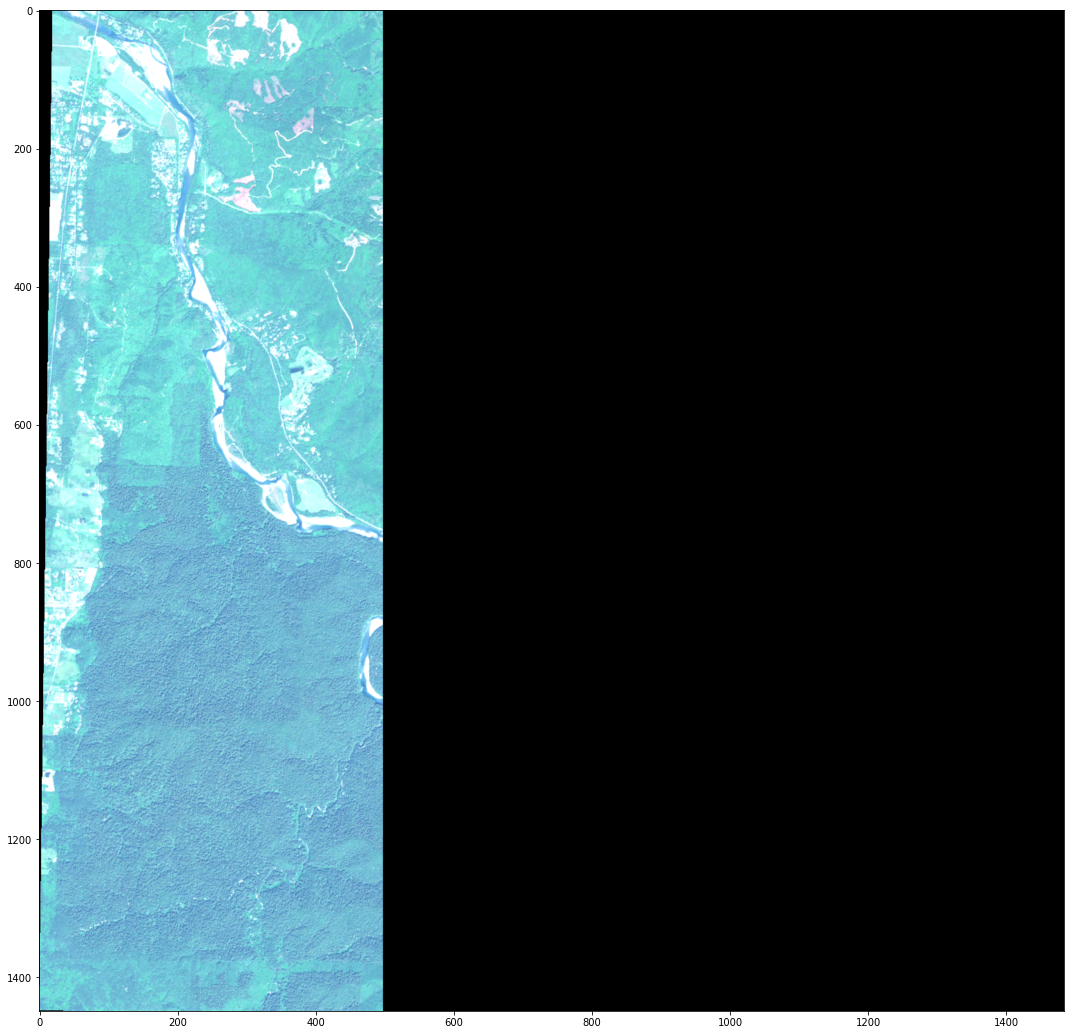

In [7]:
lowres_context = ctx.assign(resolution=10)
arr = scenes[2].ndarray("red green blue", lowres_context, mask_alpha=False)
dl.scenes.display(arr, size=15)

In [27]:
filtered_scenes = scenes.filter_coverage(ctx, 0.75)

In [28]:
len(filtered_scenes)

69

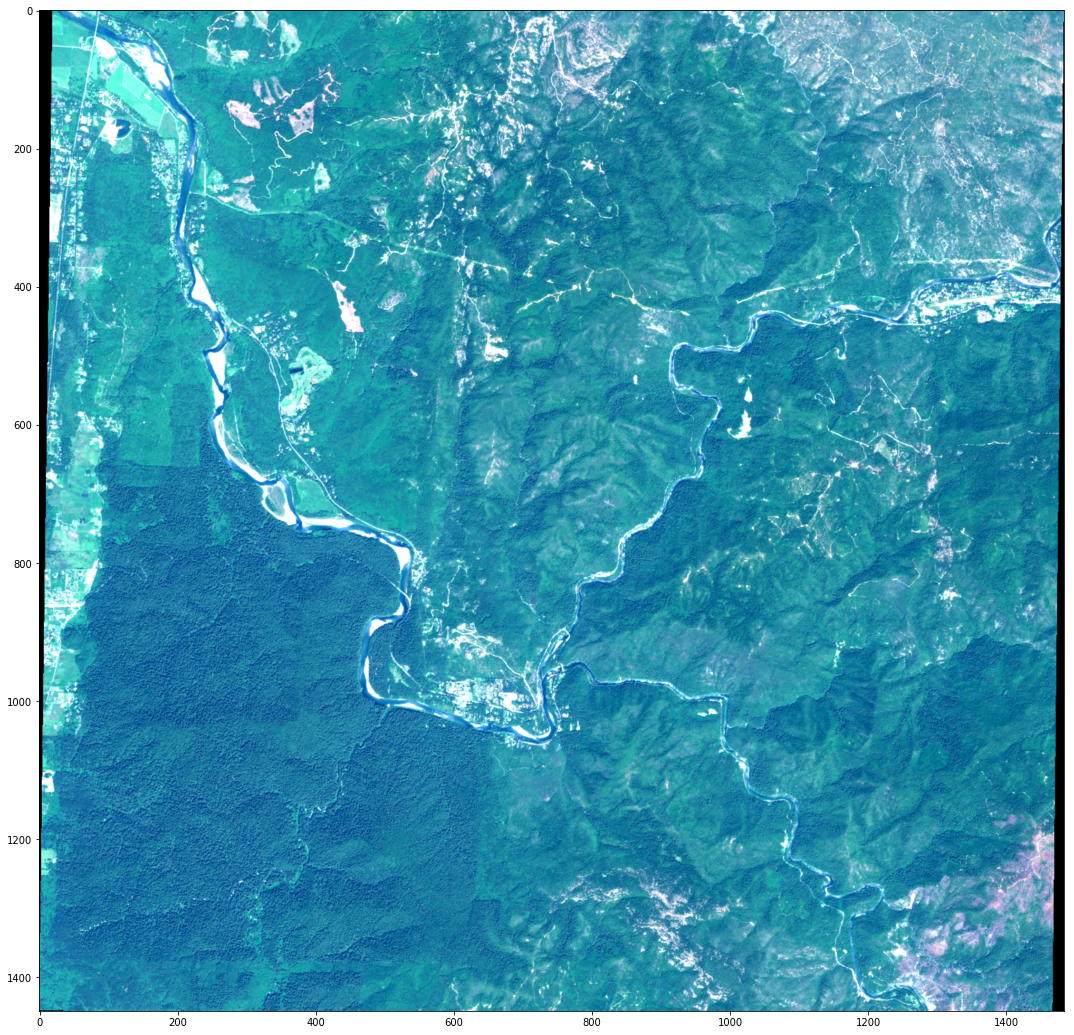

In [10]:
arr = filtered_scenes[10].ndarray("red green blue", lowres_context, mask_alpha=False)
dl.scenes.display(arr, size=15)

In [11]:
scene, ctx = dl.scenes.Scene.from_id(filtered_scenes[10].properties.id)

In [29]:
lowres_context = ctx.assign(resolution=10)

In [13]:
arr = filtered_scenes[10].ndarray("red nir swir2", lowres_context, mask_alpha=False)
dl.scenes.display(arr, size=15)

KeyboardInterrupt: 

In [ ]:
arr = filtered_scenes[10].ndarray("derived:ndvi", lowres_context, mask_alpha=False)
dl.scenes.display(arr, size=15)

In [15]:
images = []
images.append(filtered_scenes[10].properties.id)

for image in images:
    raster_client = dl.Raster()
    raster_client.raster(
        inputs=image,
        bands=['red', 'green', 'blue', 'nir'],
        scales=[[0, 5000]],
        data_type='Float64',
        cutline=smith_river,
        save=True,
        outfile_basename="tutorial_%s" % image,
        resolution=10)

In [38]:
arr = filtered_scenes[10].ndarray("red green blue nir", lowres_context, mask_alpha=False)

# Set raster metadata for rasterizing our training data.
bands, rows, cols = arr.shape
# get geo trasnform array
# ds = gdal.Open('testtt.tif')
# ds.GetGeoTransform()
geo_transform = [404820.05636920035, 5.0, 0.0, 4637488.463137395, 0.0, -5.0]
proj = 'PROJCS["WGS 84 / UTM zone 10N",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-123],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","32610"]]'
stacked = np.dstack((arr[0], arr[1], arr[2], arr[3]))

In [39]:
from osgeo import gdal
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

In [40]:
def create_mask_from_vector(vector_data_path, cols, rows, geo_transform,
                            projection, target_value=1):
    """Rasterize the given vector (wrapper for gdal.RasterizeLayer)."""
    data_source = gdal.OpenEx(vector_data_path, gdal.OF_VECTOR)
    layer = data_source.GetLayer(0)
    driver = gdal.GetDriverByName('MEM')  # In memory dataset
    target_ds = driver.Create('', cols, rows, 1, gdal.GDT_UInt16)
    target_ds.SetGeoTransform(geo_transform)
    target_ds.SetProjection(projection)
    gdal.RasterizeLayer(target_ds, [1], layer, burn_values=[target_value])
    return target_ds


def vectors_to_raster(file_paths, rows, cols, geo_transform, projection):
    """Rasterize the vectors in the given directory in a single image."""
    labeled_pixels = np.zeros((rows, cols))
    print
    for i, path in enumerate(file_paths):
        label = i+1
        ds = create_mask_from_vector(path, cols, rows, geo_transform,
                                     projection, target_value=label)
        band = ds.GetRasterBand(1)
        labeled_pixels += band.ReadAsArray()
        ds = None
    return labeled_pixels


def write_geotiff(fname, data, geo_transform, projection):
    """Create a GeoTIFF file with the given data."""
    driver = gdal.GetDriverByName('GTiff')
    rows, cols = data.shape
    dataset = driver.Create(fname, cols, rows, 1, gdal.GDT_Byte)
    dataset.SetGeoTransform(geo_transform)
    dataset.SetProjection(projection)
    band = dataset.GetRasterBand(1)
    band.WriteArray(data)
    dataset = None  # Close the file

In [41]:
train_data_path = "."

In [44]:
files = [f for f in os.listdir(train_data_path) if f.endswith('.shp')]
classes = [f.split('.')[0] for f in files]
print("There are {} classes:".format(len(classes)))
for c in classes:
    print(c)

shapefiles = [os.path.join(train_data_path, f)
              for f in files if f.endswith('.shp')]

labeled_pixels = vectors_to_raster(shapefiles, rows, cols, geo_transform,
                                   proj)
is_train = np.nonzero(labeled_pixels)
training_labels = labeled_pixels[is_train]
training_samples = stacked[is_train]

There are 4 classes:
forest
urban
bare
water


In [45]:
is_train

(array([ 295,  323,  335,  351,  352,  357,  371,  372,  373,  377,  380,
         383,  383,  392,  595,  598,  603,  629,  635,  675, 1104, 1152,
        1269, 1305, 1336, 1381, 1406]),
 array([ 384,  773,  758,  609,  590,  753,  772, 1209, 1212,  767,  249,
        1208, 1211,  241,  418,  416,  414,   55,   37,   34,  512,  542,
         507,  521, 1231,   34,  667]))

In [46]:
classifier = RandomForestClassifier(n_jobs=-1)
classifier.fit(training_samples, training_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

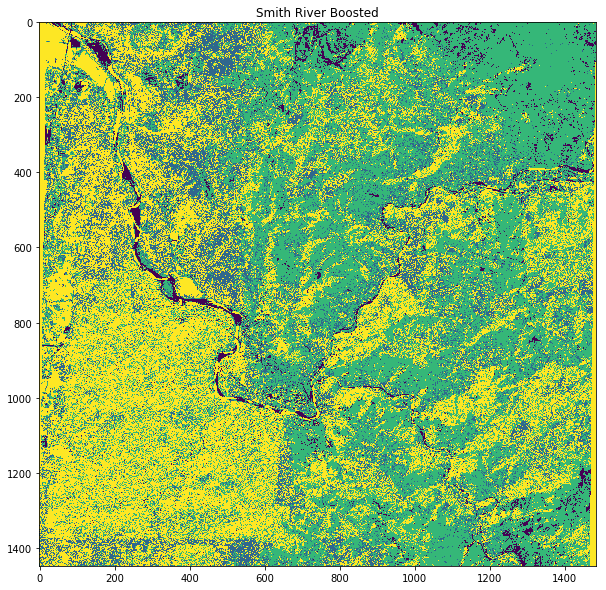

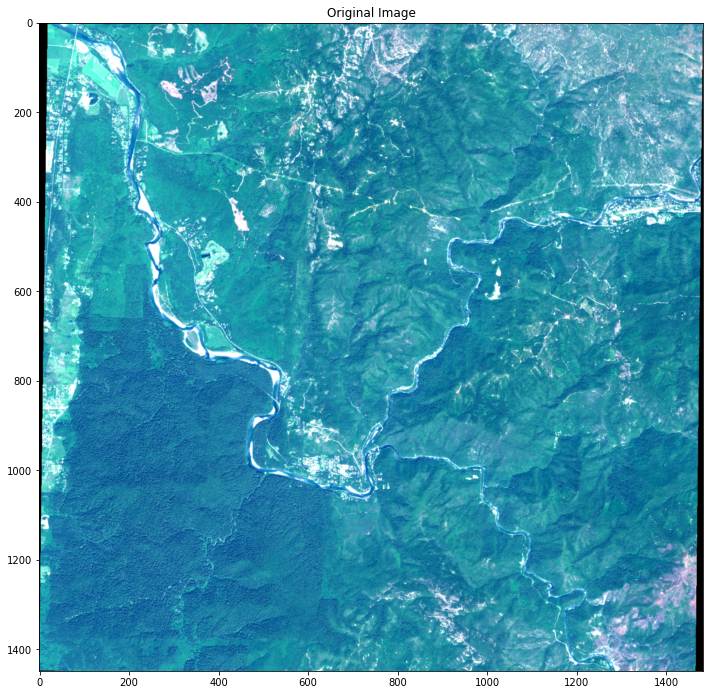

In [47]:
n_samples = rows*cols
flat_pixels = stacked.reshape((n_samples, bands))
result = classifier.predict(flat_pixels)
classification = result.reshape((rows, cols))
plt.figure(figsize=[10,10])
plt.imshow(classification)
plt.title('Smith River Boosted')

# RESET arr for view
arr = filtered_scenes[10].ndarray("red green blue", lowres_context, mask_alpha=False)
dl.scenes.display(arr, size=10, title="Original Image")